In [22]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import logging, os
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
# logging.basicConfig(level=logging.DEBUG)

BASE_PATH = "../../../../local_data/practice/"
DATA_PATH = "../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"pr_class_09_2_keras_xfer_cv/"
os.system("mkdir -p " + OUTPUT_PATH)

(train_ds, validation_ds), metadata= tfds.load(
    "cats_vs_dogs",
    data_dir=DATA_PATH,
    split=["train[:40%]", "train[40%:50%]"],
    with_info=True,
    as_supervised=True, 
)# Include labels

INFO:absl:Load dataset info from ../../../../local_data/tfds/cats_vs_dogs/4.0.0
INFO:absl:Reusing dataset cats_vs_dogs (../../../../local_data/tfds/cats_vs_dogs/4.0.0)
INFO:absl:Constructing tf.data.Dataset cats_vs_dogs for split ['train[:40%]', 'train[40%:50%]'], from ../../../../local_data/tfds/cats_vs_dogs/4.0.0


In [23]:
num_train = tf.data.experimental.cardinality(train_ds)
num_test = tf.data.experimental.cardinality(validation_ds)
print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_test}")
print("train_ds",train_ds)

Number of training samples: 9305
Number of validation samples: 2326
train_ds <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


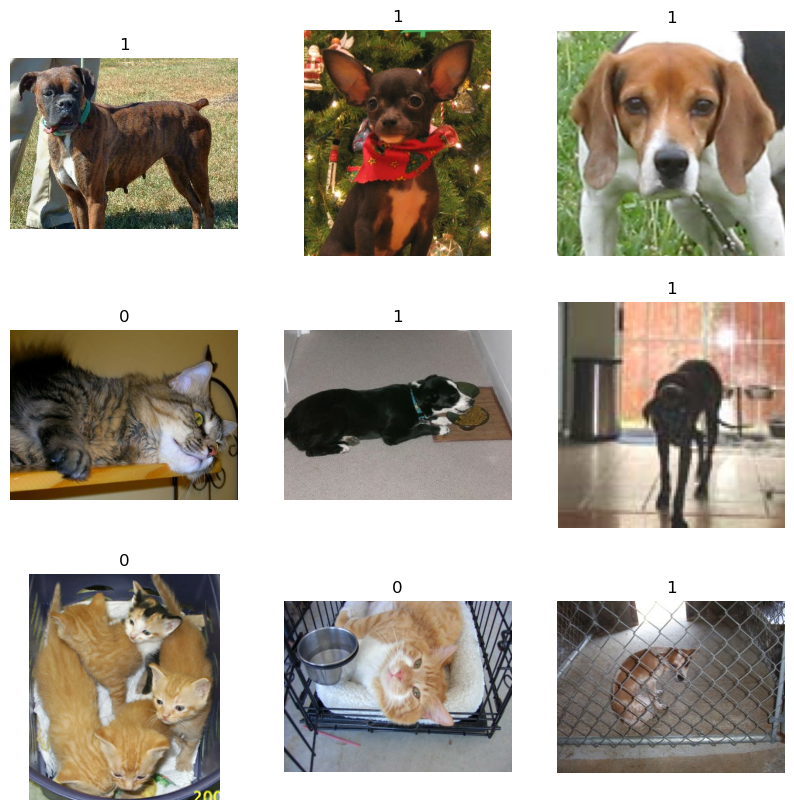

In [24]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [25]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size)/ 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size)/ 255.0, y))

In [26]:
num_train = tf.data.experimental.cardinality(train_ds)
num_test = tf.data.experimental.cardinality(validation_ds)
print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_test}")
print("train_ds",train_ds)

Number of training samples: 9305
Number of validation samples: 2326
train_ds <_MapDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


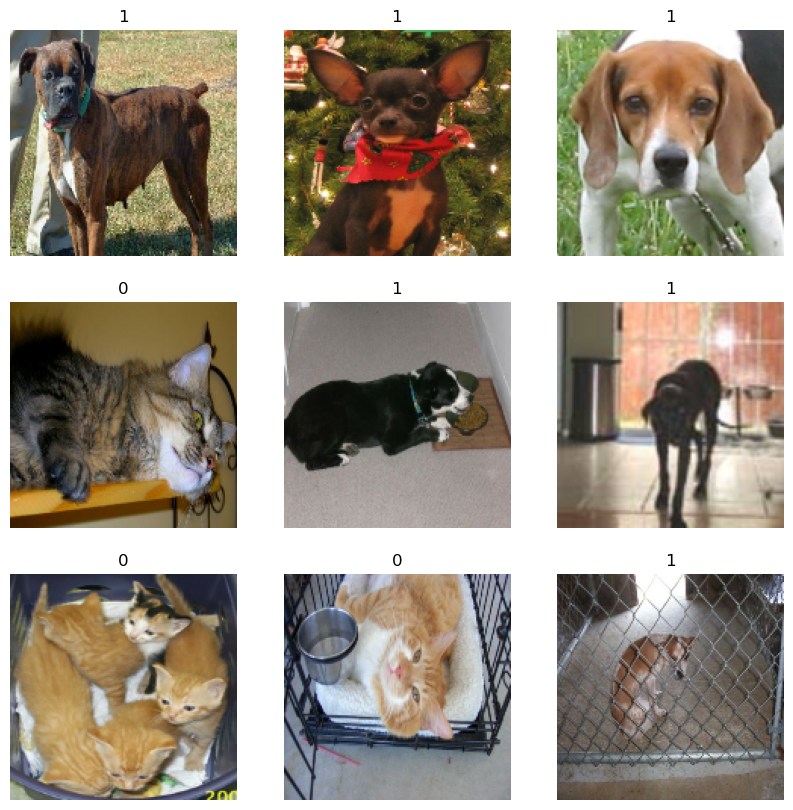

In [27]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [28]:
batch_size = 32
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache() \
.batch(batch_size).prefetch(buffer_size=10)

2025-07-02 20:26:30.389503: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


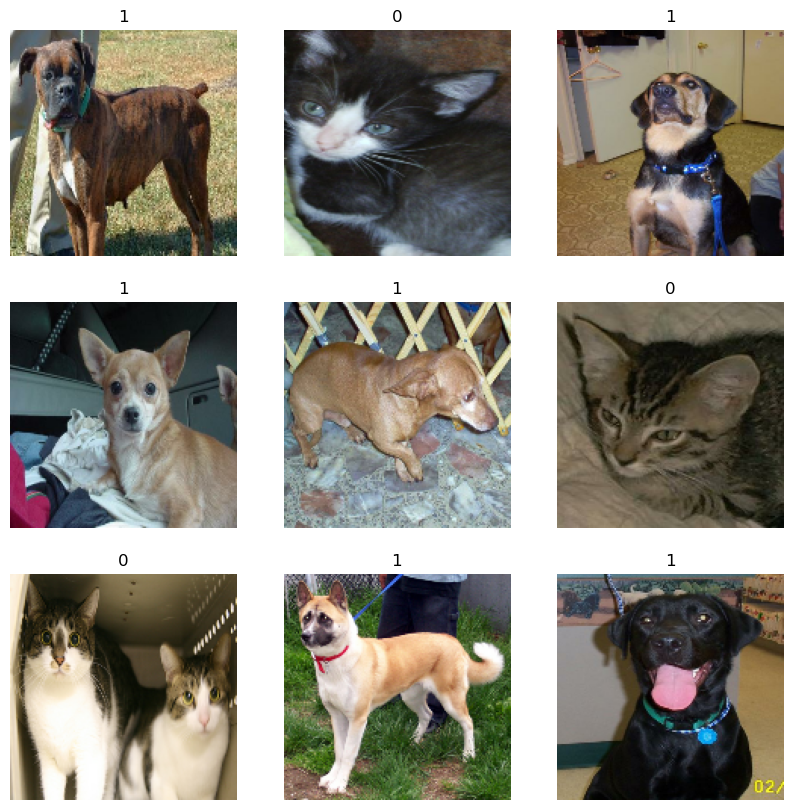

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i])
    # plt.imshow((image * 255).astype(np.uint8))
    plt.title(int(label[i]))
    plt.axis("off")

In [30]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

2025-07-02 20:32:05.374604: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 86402560 bytes after encountering the first element of size 8640256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-07-02 20:32:05.376284: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


first_image.shape= (150, 150, 3)
augmented_image.shape= (1, 150, 150, 3)
augmented_image.shape= (1, 150, 150, 3)
augmented_image.shape= (1, 150, 150, 3)
augmented_image.shape= (1, 150, 150, 3)
augmented_image.shape= (1, 150, 150, 3)
augmented_image.shape= (1, 150, 150, 3)
augmented_image.shape= (1, 150, 150, 3)
augmented_image.shape= (1, 150, 150, 3)
augmented_image.shape= (1, 150, 150, 3)


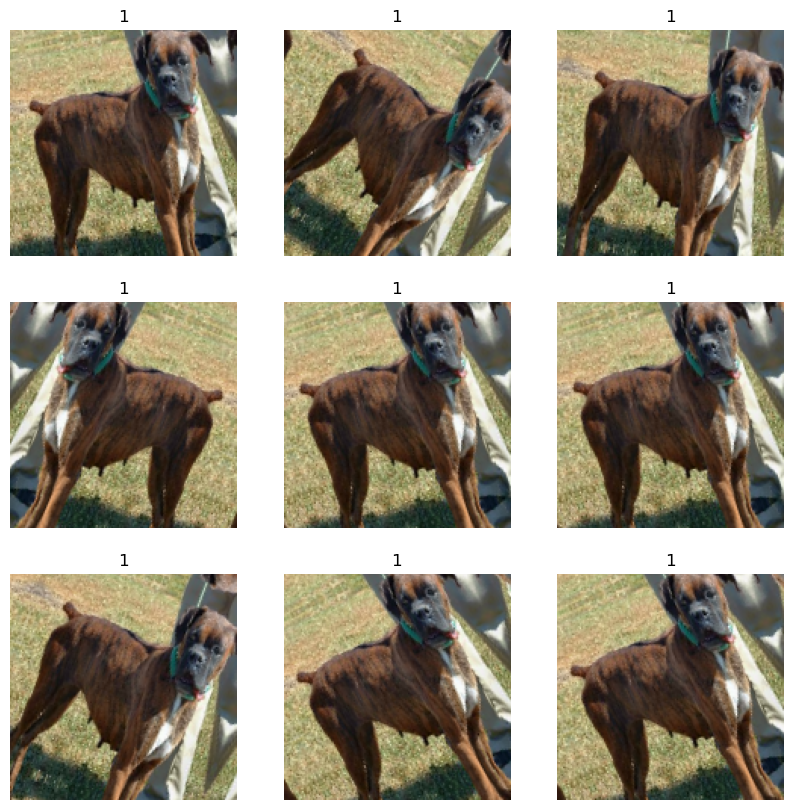

In [ ]:
import numpy as np
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    # first_image = images[0]*255.0
    print("first_image.shape=",first_image.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        # print("augmented_image.shape=",augmented_image.shape)
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [35]:
base_model = keras.applications.Xception(
    weights="imagenet", # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
) # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs) # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers.
# We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning,
# so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [36]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20


2025-07-02 20:39:51.233999: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 86402560 bytes after encountering the first element of size 8640256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


144/291 [=============>................] - ETA: 1:31 - loss: 0.6932 - binary_accuracy: 0.4978

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


261/291 [=========================>....] - ETA: 18s - loss: 0.6932 - binary_accuracy: 0.4983

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


274/291 [===========================>..] - ETA: 10s - loss: 0.6932 - binary_accuracy: 0.4983

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


277/291 [===========================>..] - ETA: 8s - loss: 0.6932 - binary_accuracy: 0.4979

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


291/291 [==============================] - ETA: 0s - loss: 0.6932 - binary_accuracy: 0.4983

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


291/291 [==============================] - 229s 777ms/step - loss: 0.6932 - binary_accuracy: 0.4983 - val_loss: 0.6931 - val_binary_accuracy: 0.5052
Epoch 2/20
291/291 [==============================] - 237s 815ms/step - loss: 0.6930 - binary_accuracy: 0.4983 - val_loss: 0.6930 - val_binary_accuracy: 0.5052
Epoch 3/20
291/291 [==============================] - 250s 859ms/step - loss: 0.6929 - binary_accuracy: 0.4983 - val_loss: 0.6928 - val_binary_accuracy: 0.5052
Epoch 4/20
291/291 [==============================] - 224s 772ms/step - loss: 0.6929 - binary_accuracy: 0.4983 - val_loss: 0.6927 - val_binary_accuracy: 0.5052
Epoch 5/20
291/291 [==============================] - 221s 760ms/step - loss: 0.6928 - binary_accuracy: 0.4983 - val_loss: 0.6926 - val_binary_accuracy: 0.5052
Epoch 6/20
291/291 [==============================] - ETA: 0s - loss: 0.6925 - binary_accuracy: 0.4983

KeyboardInterrupt: 